### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [4]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


`models` (returned from `load_models`) is a list of InstancedModule objects, one for each training checkpoint that we chose to save. For most runs, we only save the final checkpoints, so `len(models)==1`

For efficiency during training, the InstancedModule object contains 100 different instances starting from different random initializations. 

Here, we look only at the one with best test accuracy.

In [5]:
loss_dict = test_loss(models[-1].to(device), data)
print(loss_dict['G0_loss'].min(), loss_dict['G0_loss'].argmin())
instance = loss_dict['G0_loss'].argmin().item()
model = models[-1][instance].to(device)

tensor(0.0296) tensor(71)


`MLP3` architecture is
$$f(z\mid x, y) = W_u(z)\cdot\text{ReLU}[W_h(W_l(x)+W_r(y))]] = \sum_i w_u^i(z) \text{ReLU}[w_l^i(x)+w_r^i(y)]$$
where $w_u^i, w_l^i, w_r^i\in\mathbb{R}^G$ are the columns of $W_u, (W_hW_l)^{\top}, (W_hW_r)^{\top}$ respectively.

In [6]:
lneurons, rneurons = model.get_neurons()
uneurons = model.unembedding.data.detach()
lneurons, rneurons, uneurons = lneurons.squeeze(0).to('cpu'), rneurons.squeeze(0).to('cpu'), uneurons.squeeze(0).to('cpu').T
lneurons.shape, rneurons.shape, uneurons.shape

(torch.Size([120, 128]), torch.Size([120, 128]), torch.Size([120, 128]))

### Neurons are irrep-sparse

I.e., each neuron is a linear combination of matrix entries of some irrep.

That is, for each $i$, there exists an irrep $\rho_i\colon G\to\text{GL}(\mathbb{R}^d)$ such that, for some $A_i,B_i,C_i$,
$$w_l^i(x) \approx \text{tr}(\rho_i(x) A_i)$$
$$w_r^i(y) \approx \text{tr}(\rho_i(y) B_i)$$
$$w_u^i(z) \approx \text{tr}(\rho_i(z) C_i)$$

(This was first noticed by Chughtai et al.)

**Notation**: 4d-0 is the 1st degree 4 irrep, 4d-1 is the 2nd, etc. Ordering is arbitrary but is consistent between runs (I think)

Note that 4d-2 is a real irrep (Frobenius-Schur indicator = 1) and thus has entries orthogonal over $\mathbb{R}^G$. This is not true of 4d-0 or 4d-1.

In [7]:
irreps = group.get_real_irreps(verbose=True)
print(irreps.keys())

dict_keys(['1d-0', '4d-0', '5d-0', '6d-0', '5d-1', '4d-1', '1d-1'])


In [8]:
# Get orthogonal basis for each irrep
irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
4d-0 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
6d-0 torch.Size([120, 36])
5d-1 torch.Size([120, 25])
4d-1 torch.Size([120, 16])
1d-1 torch.Size([120, 1])


In [9]:
# Proportion of variance explained by each irrep, for each neuron
lexpl, rexpl, uexpl = dict(), dict(), dict()

for name, basis in irrep_bases.items():
    lproj = basis.T @ lneurons
    lexpl[name] = (basis.T @ lneurons).norm(dim=0)**2 / (lneurons.norm(dim=0)**2 + 1e-8)
    rexpl[name] = (basis.T @ rneurons).norm(dim=0)**2 / (rneurons.norm(dim=0)**2 + 1e-8)
    uexpl[name] = (basis.T @ uneurons).norm(dim=0)**2 / (uneurons.norm(dim=0)**2 + 1e-8)

In [10]:
lexpl_max, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)

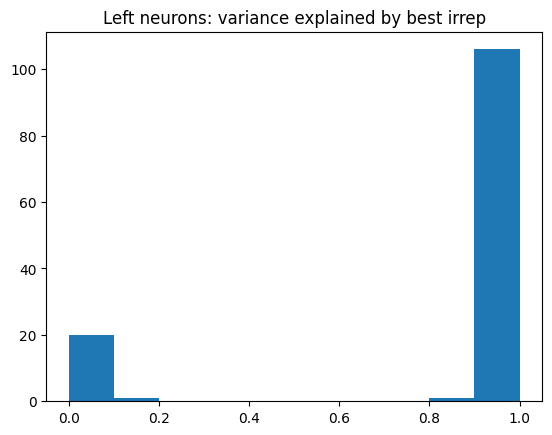

In [11]:
plt.hist(lexpl_max.tolist())
plt.title('Left neurons: variance explained by best irrep')
plt.show()

In [37]:
irrep_idx_d = {
    name: [
        i for i in range(lneurons.shape[-1]) 
        if lexpl[name][i].item() > 0.9999 and lneurons[:,i].norm() > 1e-4
    ]
    for name in irreps
}
for k, v in irrep_idxs.items():
    print(k, len(v))

1d-0 2
4d-0 0
5d-0 0
6d-0 0
5d-1 0
4d-1 97
1d-1 0


In [39]:
irrep_name = '4d-1'
irrep_d = 4
irrep_lneurons = lneurons[:, irrep_idxs[irrep_name]]
irrep_rneurons = rneurons[:, irrep_idxs[irrep_name]]
irrep_uneurons = uneurons[:, irrep_idxs[irrep_name]]
irrep = irreps[irrep_name]
irrep_idxs = irrep_idx_d[irrep_name]

In [40]:
flat_irrep = einops.rearrange(irrep, 'n d1 d2 -> n (d1 d2)')
# Project neurons onto subspace spanned by flat_irrep
A_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ irrep_lneurons)
B_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ irrep_rneurons)
C_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ irrep_uneurons)
A = einops.rearrange(A_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mT
B = einops.rearrange(B_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mT
C = einops.rearrange(C_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mT
A.shape, B.shape, C.shape

(torch.Size([97, 4, 4]), torch.Size([97, 4, 4]), torch.Size([97, 4, 4]))

### $C_i\approx A_iB_i$

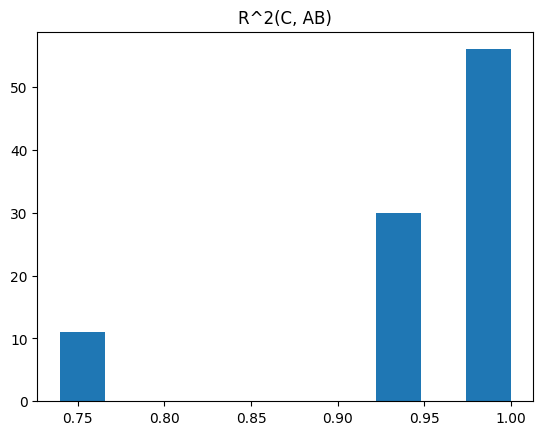

In [41]:
x = einops.rearrange(A @ B, 'm d1 d2 -> m (d1 d2)')
y = einops.rearrange(C, 'm d1 d2 -> m (d1 d2)')
coef = (x * y).sum(dim=-1) / (x * x).sum(dim=-1)
yhat = coef.unsqueeze(1) * x
r2 = (yhat - y).norm(dim=-1).pow(2) / y.norm(dim=-1).pow(2)
plt.hist(r2.tolist())
plt.title('R^2(C, AB)')
plt.show()

### $A_i, B_i, C_i$ are almost rank 1

Thus, we can write
$$A_i\approx a_ib_i^\top$$
$$B_i\approx c_id_i^\top$$
$$C_i\approx A_iB_i\approx \langle b_i, c_i\rangle a_i d_i^\top$$

In [42]:
a, b, c, d, A_expl, B_expl = [], [], [], [], [], []
for i in range(len(irrep_idxs)):
    lu, ls, lv = t.svd(A[i])
    ru, rs, rv = t.svd(B[i])
    a.append(lu[:,0])
    b.append(lv[0])
    c.append(ru[:,0])
    d.append(rv[0])
    A_expl.append(ls[0].pow(2) / ls.pow(2).sum())
    B_expl.append(rs[0].pow(2) / rs.pow(2).sum())
a, b, c, d = t.stack(a, dim=0), t.stack(b, dim=0), t.stack(c, dim=0), t.stack(d, dim=0)
min(A_expl), min(B_expl)

(tensor(1.0000), tensor(1.0000))

### $a_i$ is approx constant and $c_i$ are clustered

In [44]:
a_mean = a.mean(dim=0)
(a - a_mean).norm() / a.norm()

tensor(0.0006)

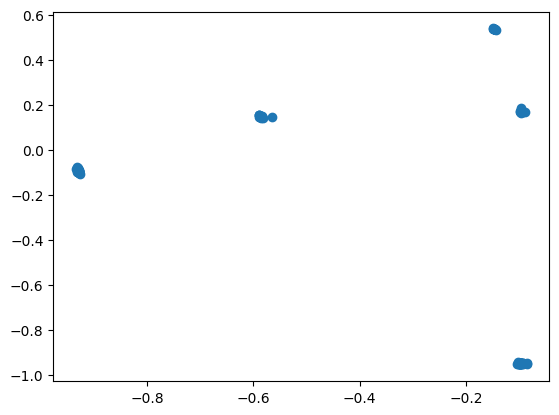

In [53]:
plt.scatter(c[:,0].tolist(), c[:,1].tolist())
plt.show()

In [63]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(c.numpy())
# kmeans.score is negative average squared l2 dist to cluster centroid
print(-kmeans.score(c.numpy()) / c.norm()**2)
c_mean = t.tensor(kmeans.cluster_centers_)
c_mean.shape

tensor(8.4205e-05)


torch.Size([5, 4])

In [64]:
corr = c_mean @ c_mean.T
corr

tensor([[ 1.0000, -0.2529,  0.2503, -0.2512, -0.2482],
        [-0.2529,  0.9999,  0.2474, -0.2487, -0.2503],
        [ 0.2503,  0.2474,  0.9999,  0.2494,  0.2486],
        [-0.2512, -0.2487,  0.2494,  0.9999, -0.2527],
        [-0.2482, -0.2503,  0.2486, -0.2527,  0.9999]])

**Note:** 5 unit vectors evenly spaced in 4 dimensions will all have pairwise inner product = -1/4.

The +1/4 inner products above are due to ambiguity in the sign of singular vectors.

Let's transform the $c_i$ and $d_i$ to make everything -1/4

In [65]:
sign_mean = t.tensor(
    [1.] + t.sign(-corr[0,1:]).tolist()
)
t.diag(sign_mean) @ c_mean @ c_mean.T @ t.diag(sign_mean)

tensor([[ 1.0000, -0.2529, -0.2503, -0.2512, -0.2482],
        [-0.2529,  0.9999, -0.2474, -0.2487, -0.2503],
        [-0.2503, -0.2474,  0.9999, -0.2494, -0.2486],
        [-0.2512, -0.2487, -0.2494,  0.9999, -0.2527],
        [-0.2482, -0.2503, -0.2486, -0.2527,  0.9999]])

In [66]:
sign = t.zeros(c.shape[0])
for i in range(c.shape[0]):
    sign[i] = sign_mean[kmeans.labels_[i]]
c = t.diag(sign) @ c
d = t.diag(sign) @ d
kmeans = KMeans(n_clusters=5).fit(c.numpy())
print(-kmeans.score(c.numpy()))
c_mean = t.tensor(kmeans.cluster_centers_)
c_mean.shape
corr = c_mean @ c_mean.T
corr

0.008167913183569908


tensor([[ 0.9999, -0.2474, -0.2487, -0.2529, -0.2503],
        [-0.2474,  0.9999, -0.2494, -0.2503, -0.2486],
        [-0.2487, -0.2494,  0.9999, -0.2512, -0.2527],
        [-0.2529, -0.2503, -0.2512,  1.0000, -0.2482],
        [-0.2503, -0.2486, -0.2527, -0.2482,  0.9999]])

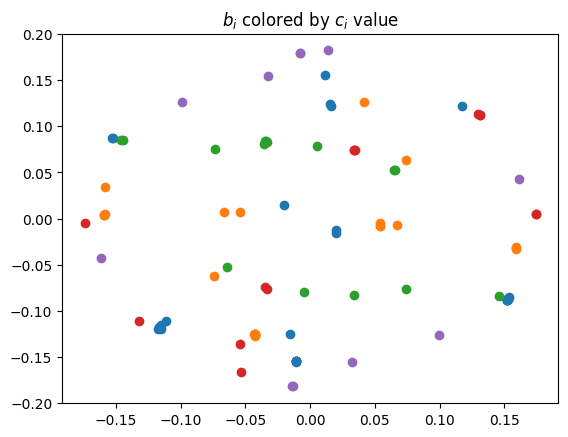

In [67]:
b_pcs = t.svd(b)[0][:,:2]
for label in range(5):
    cluster = [j for j in range(c.shape[0]) if kmeans.labels_[j].item() == label]
    plt.scatter(b_pcs[cluster, 0], b_pcs[cluster, 1])
plt.title('$b_i$ colored by $c_i$ value')
plt.show()

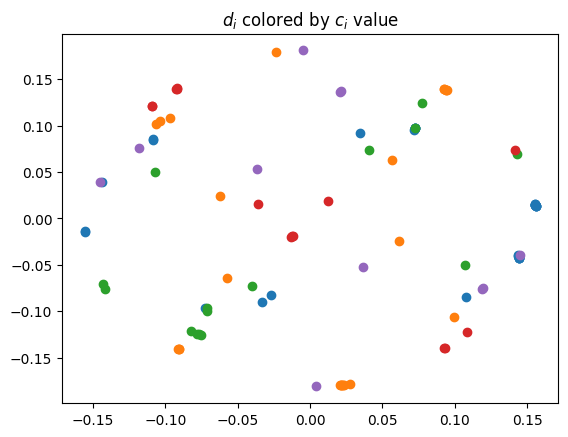

In [68]:
d_pcs = t.svd(d)[0][:,:2]
for label in range(5):
    cluster = [j for j in range(c.shape[0]) if kmeans.labels_[j].item() == label]
    plt.scatter(d_pcs[cluster, 0], d_pcs[cluster, 1])
plt.title('$d_i$ colored by $c_i$ value')
plt.show()

In [69]:
dhat = b @ t.linalg.inv(b.T @ b) @ b.T @ d
(d - dhat).norm()**2 / d.norm()**2

tensor(0.6697)

In [70]:
for label in range(5):
    cluster = [j for j in range(c.shape[0]) if kmeans.labels_[j].item() == label]
    b_cl, d_cl = b[cluster], d[cluster]
    dhat = b_cl @ t.linalg.inv(b_cl.T @ b_cl) @ b_cl.T @ d_cl
    print((d_cl - dhat).norm()**2 / d_cl.norm()**2)

tensor(0.0125)
tensor(0.1024)
tensor(0.0504)
tensor(0.2336)
tensor(0.0793)


In [71]:
t.svd(b)[1], t.svd(d)[1]

(tensor([5.7182, 5.3562, 4.6354, 3.7584]),
 tensor([6.3006, 5.3153, 4.7454, 2.5557]))

### Activations are clustered

In [72]:
embedding_left = model.embedding_left.squeeze(0)
embedding_right = model.embedding_right.squeeze(0)
linear = model.linear.squeeze(0)
unembedding = model.unembedding.squeeze(0).T
# There's a degree of freedom with embedding/unembedding norm.
# Rescale so that each unembedding column is norm 1
u_norm = unembedding.norm(dim=0)
unembedding = unembedding / u_norm
linear = linear * u_norm

In [73]:
N = len(group)
inputs = t.tensor(list(product(range(N), repeat=2)), device=device)
l_in, r_in = inputs[..., 0], inputs[..., 1]
l_onehot = F.one_hot(l_in, num_classes=N).float()
r_onehot = F.one_hot(r_in, num_classes=N).float()
l_embed = einops.einsum(l_onehot, embedding_left, 'batch group, group embed -> batch embed')
r_embed = einops.einsum(r_onehot, embedding_right, 'batch group, group embed -> batch embed')
l_act = einops.einsum(l_embed, linear, 'batch embed, embed hid -> batch hid')
r_act = einops.einsum(r_embed, linear, 'batch embed, embed hid -> batch hid')
l_act = l_act[:, irrep_idxs]
r_act = r_act[:, irrep_idxs]

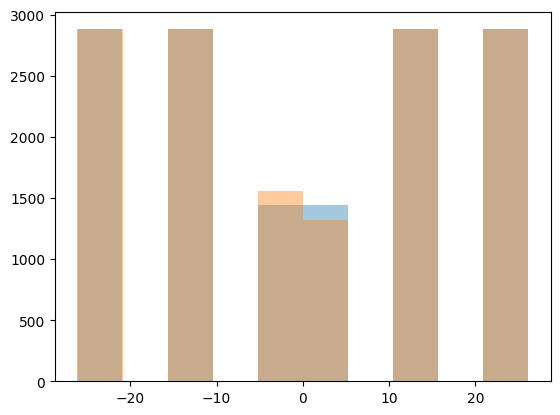

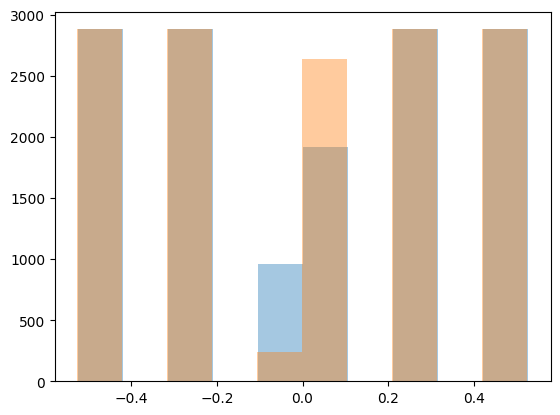

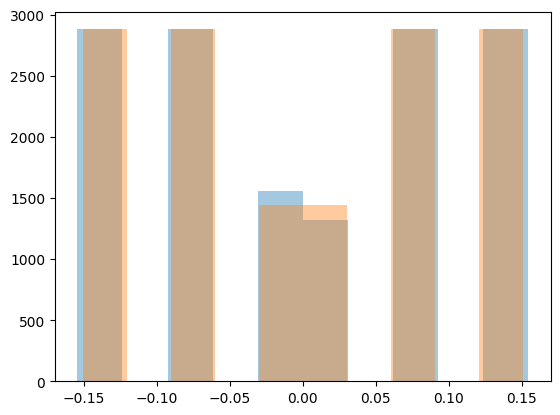

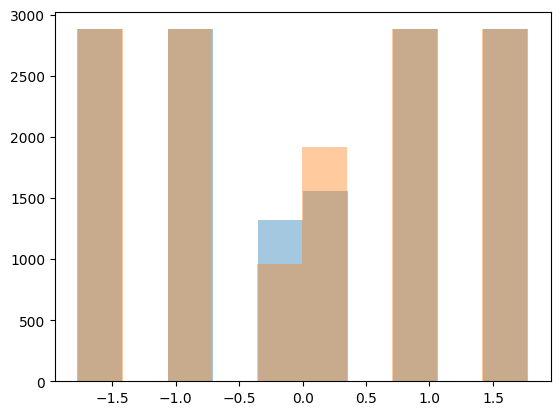

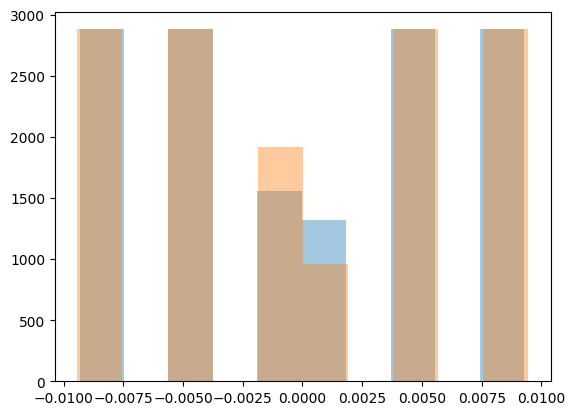

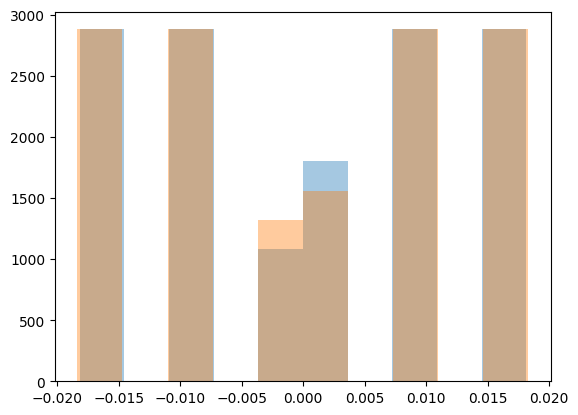

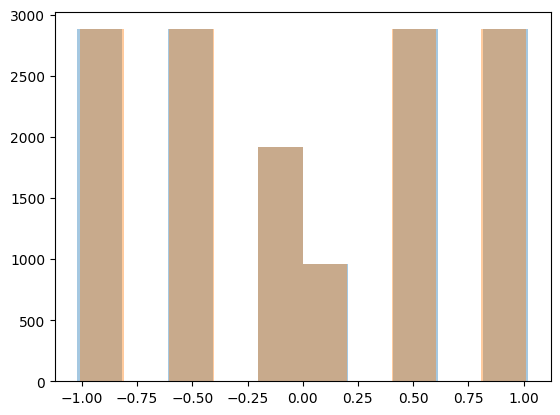

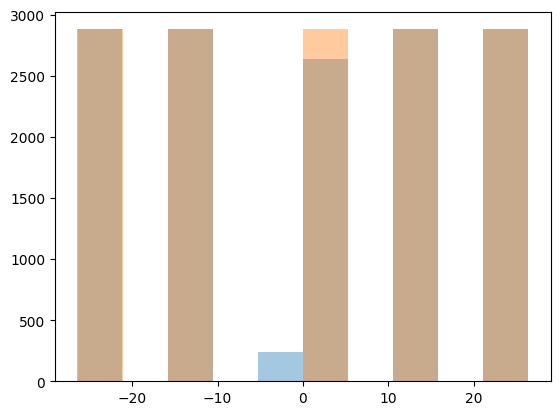

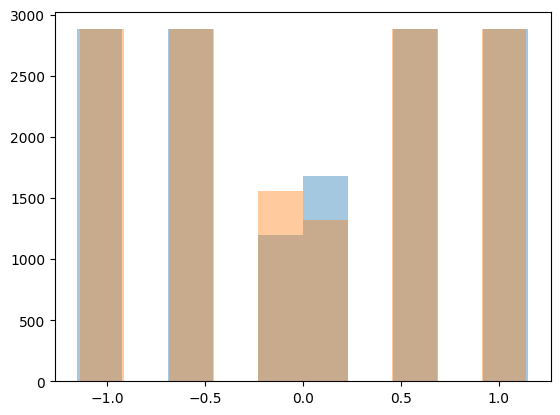

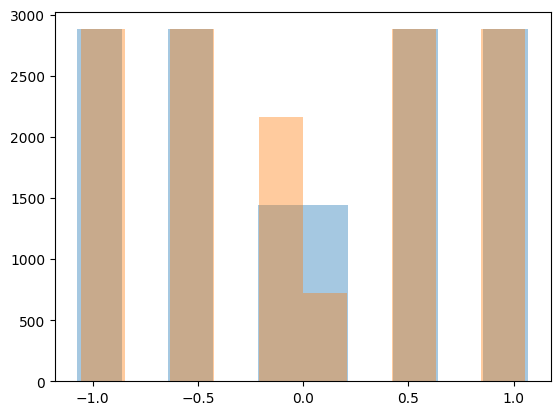

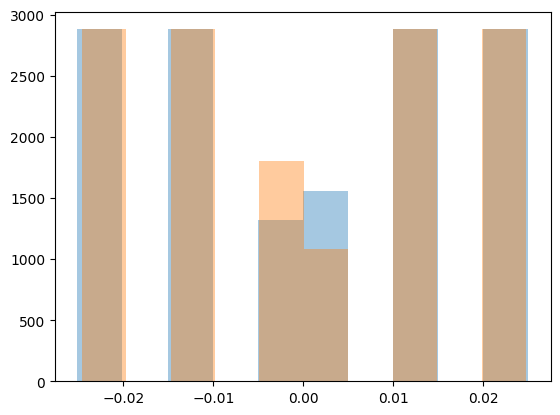

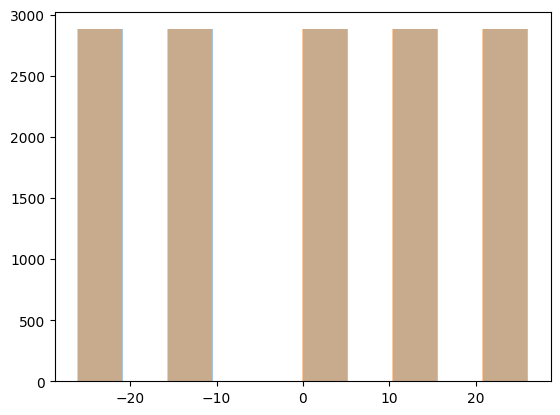

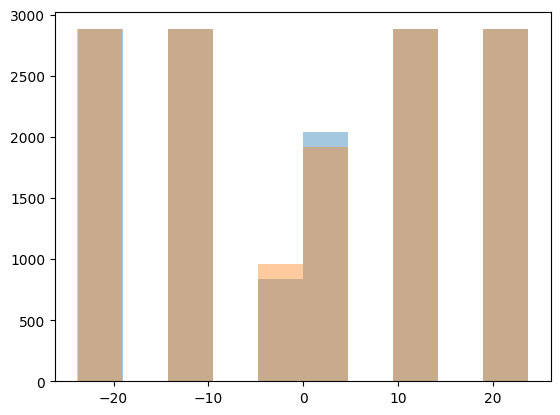

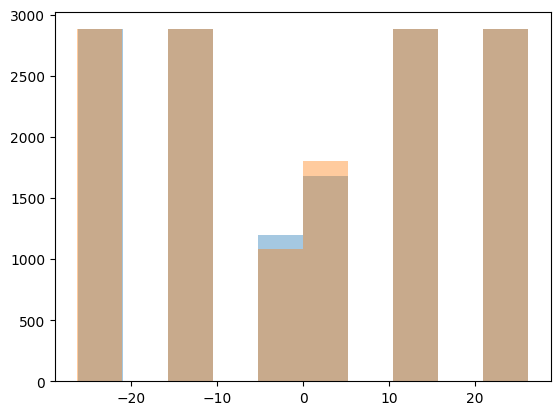

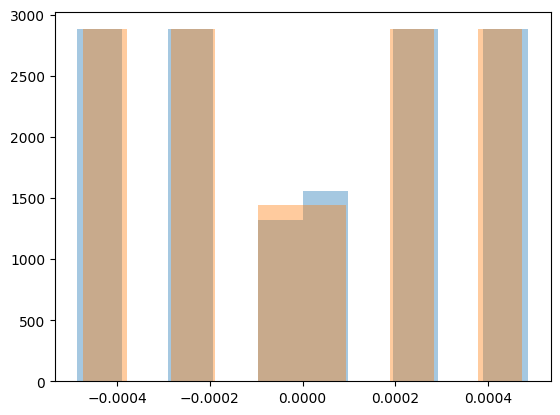

In [74]:
for i in range(15):
    plt.hist(l_act[:,i].tolist(), alpha=0.4)
    plt.hist(r_act[:,i].tolist(), alpha=0.4)
    plt.show()

In [178]:
(l_act == r_act)

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True]])